### Imports

In [329]:
import os, urllib.request
import cv2, numpy as np, matplotlib.pyplot as plt

import mediapipe as mp
from mediapipe. tasks import python
from mediapipe.tasks.python import vision
from mediapipe. framework.formats import landmark_pb2
from mediapipe. python.solutions import drawing_utils as mp_drawing
from mediapipe.python.solutions import drawing_styles as mp_styles
from mediapipe.python.solutions import face_mesh

### Download Mediapipe model and create landmarks

In [330]:
MODEL_URL = (
    "https://storage.googleapis.com/mediapipe-models/face_landmarker/"
    "face_landmarker/float16/1/face_landmarker.task"
)
MODEL_PATH = "face_landmarker.task"

if not os.path.exists(MODEL_PATH):
    urllib.request.urlretrieve(MODEL_URL, MODEL_PATH)

base_options = python.BaseOptions(model_asset_path=MODEL_PATH)
options = vision.FaceLandmarkerOptions(
    base_options=base_options,
    num_faces=1,
    output_face_blendshapes=False,
    output_facial_transformation_matrixes=False,
)
face_landmarker = vision.FaceLandmarker.create_from_options(options)

W0000 00:00:1767327853.849345   95123 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1767327853.851904   95126 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1767327853.856576   95126 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


### Region Definitions

In [331]:
# (custom polygons) and helpers LEFT CHEEK is from photo pov
LEFT_CHEEK  = [116, 123, 187, 207, 206, 203, 142, 232, 229, 111]
RIGHT_CHEEK = [340, 345, 352, 411, 427, 426, 423, 355, 357, 450] 
FOREHEAD    = [9, 107, 69, 104, 103, 67, 109, 10, 338, 297, 332, 333, 299, 336, 9]

            # = [103, 67, 109, 10, 338, 297, 332
               # , 104, 69, 108, 337, 299, 333
               # , 9]

def bbox_from_landmarks(landmarks, w, h, pad=0.02):
    xs = [lm.x for lm in landmarks]; ys = [lm.y for lm in landmarks]
    x0 = max(0, int((min(xs) - pad) * w))
    x1 = min(w, int((max(xs) + pad) * w))
    y0 = max(0, int((min(ys) - pad) * h))
    y1 = min(h, int((max(ys) + pad) * h))
    return x0, y0, x1, y1

def draw_polygons(img, landmarks, regions, color=(0,255,255), thickness=1):
    h, w, _ = img.shape
    out = img.copy()
    for region in regions:
        pts = np.array([(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in region], np.int32)
        cv2.polylines(out, [pts], isClosed=True, color=color, thickness=thickness, lineType=cv2.LINE_AA)
    return out

### Debug Cell - Draw EVERYTHING (bbox, mesh, contours, polygons)

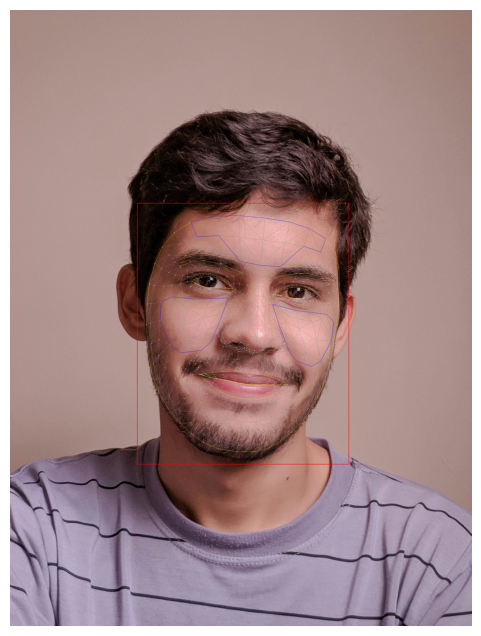

In [332]:
def draw_overlays(image_bgr, result, landmarks,
                  box_color=(0,0,255),
                  lm_color=(255,0,0),
                  lm_radius=1):
    dbg = image_bgr.copy()
    h, w, _ = dbg.shape

    # detector bbox if available
    drew_box = False
    if getattr(result, "face_detections", None):
        for det in result.face_detections:
            rel = det.bounding_box
            x0, y0 = int(rel.origin_x), int(rel.origin_y)
            x1, y1 = x0 + int(rel.width), y0 + int(rel.height)
            cv2.rectangle(dbg, (x0, y0), (x1, y1), box_color, 2)
            drew_box = True
    if not drew_box: 
        x0, y0, x1, y1 = bbox_from_landmarks(landmarks, w, h)
        cv2.rectangle(dbg, (x0, y0), (x1, y1), box_color, 2)

    # CONVERT Tasks API landmarks to protobuf format
    lm_proto = landmark_pb2.NormalizedLandmarkList()
    for lm in landmarks:
        lm_proto.landmark.append(
            landmark_pb2.NormalizedLandmark(x=lm.x, y=lm.y, z=lm.z)
        )

    # draw tessellation and contours
    mp_drawing. draw_landmarks(
        image=dbg,
        landmark_list=lm_proto,
        connections=face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=mp_drawing.DrawingSpec(color=lm_color, thickness=1, circle_radius=lm_radius),
        connection_drawing_spec=mp_styles.get_default_face_mesh_tesselation_style(),
    )
    mp_drawing.draw_landmarks(
        image=dbg,
        landmark_list=lm_proto,
        connections=face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing.DrawingSpec(color=lm_color, thickness=1, circle_radius=lm_radius),
    )

    # custom polygons
    dbg = draw_polygons(dbg, landmarks, [LEFT_CHEEK, RIGHT_CHEEK, FOREHEAD], color=(255,0,0), thickness=1)
    return dbg

image_path = "/home/freekitkallos/Downloads/man_test.jpg"  # set your path here
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(image_path)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb)
result = face_landmarker.detect(mp_image)

if not result.face_landmarks:
    print("No face detected")
else:
    landmarks = result.face_landmarks[0]
    dbg = draw_overlays(image, result, landmarks,
                        box_color=(0, 0, 255),  # red bbox
                        lm_color=(0, 255, 255))  # yellow landmarks
    # Show inline in notebook
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,8))
    plt.imshow(cv2.cvtColor(dbg, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

### CLAHE LAB Standardisation for Colour Analysis

In [333]:
def apply_clahe_lab(image_bgr, clip_limit=2.0, grid_size=(8, 8)):
    """
    Apply CLAHE in LAB color space. 
    Only normalizes Lightness, preserving color information (A and B channels).
    """
    lab = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    l_clahe = clahe.apply(l)
    
    lab_clahe = cv2.merge([l_clahe, a, b])
    return cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)


def create_region_mask(image_shape, landmarks, region_indices):
    """Create a binary mask for a polygonal region."""
    h, w = image_shape[:2]
    mask = np. zeros((h, w), dtype=np.uint8)
    
    pts = np.array([(int(landmarks[i].x * w), int(landmarks[i].y * h)) 
                    for i in region_indices], np.int32)
    cv2.fillPoly(mask, [pts], 255)
    
    return mask


def get_average_skin_color(image_bgr, landmarks, region_indices, 
                           normalize_lighting=True, 
                           clip_limit=2.0,
                           color_space='BGR'):
    """
    Extract average skin color from a region.
    
    Args:
        image_bgr:  Input image in BGR format
        landmarks: Face landmarks from MediaPipe
        region_indices: List of landmark indices defining the region
        normalize_lighting: Whether to apply CLAHE before sampling
        clip_limit:  CLAHE clip limit (higher = more contrast)
        color_space: Output color space ('BGR', 'RGB', 'LAB', 'HSV')
    
    Returns:
        tuple: (average_color, mask, processed_image)
    """
    # Step 1: Optionally normalize lighting
    if normalize_lighting: 
        processed = apply_clahe_lab(image_bgr, clip_limit=clip_limit)
    else: 
        processed = image_bgr.copy()
    
    # Step 2: Create mask for the region
    mask = create_region_mask(image_bgr.shape, landmarks, region_indices)
    
    # Step 3: Calculate mean color within the masked region
    mean_bgr = cv2.mean(processed, mask=mask)[:3]  # cv2.mean returns (B, G, R, 0)
    
    # Step 4: Convert to requested color space
    if color_space == 'BGR':
        avg_color = mean_bgr
    elif color_space == 'RGB': 
        avg_color = (mean_bgr[2], mean_bgr[1], mean_bgr[0])
    elif color_space == 'LAB':
        # Convert the mean BGR to LAB
        bgr_pixel = np.uint8([[list(mean_bgr)]])
        lab_pixel = cv2.cvtColor(bgr_pixel, cv2.COLOR_BGR2LAB)
        avg_color = tuple(lab_pixel[0, 0])
    elif color_space == 'HSV': 
        bgr_pixel = np.uint8([[list(mean_bgr)]])
        hsv_pixel = cv2.cvtColor(bgr_pixel, cv2.COLOR_BGR2HSV)
        avg_color = tuple(hsv_pixel[0, 0])
    else:
        raise ValueError(f"Unknown color space: {color_space}")
    
    return avg_color, mask, processed


def analyze_skin_colors(image_bgr, landmarks, normalize_lighting=True):
    """
    Analyze skin color across multiple face regions.
    
    Returns a dict with average colors for each region.
    """
    regions = {
        'left_cheek': LEFT_CHEEK,
        'right_cheek': RIGHT_CHEEK,
        'forehead':  FOREHEAD,
    }
    
    results = {}
    
    # Process once for efficiency
    if normalize_lighting: 
        processed = apply_clahe_lab(image_bgr)
    else: 
        processed = image_bgr
    
    for region_name, indices in regions.items():
        mask = create_region_mask(image_bgr.shape, landmarks, indices)
        mean_bgr = cv2.mean(processed, mask=mask)[:3]
        
        # Store in multiple color spaces
        bgr_pixel = np.uint8([[list(mean_bgr)]])
        
        results[region_name] = {
            'BGR': tuple(map(int, mean_bgr)),
            'RGB': tuple(map(int, (mean_bgr[2], mean_bgr[1], mean_bgr[0]))),
            'LAB': tuple(map(int, cv2.cvtColor(bgr_pixel, cv2.COLOR_BGR2LAB)[0, 0])),
            'HSV':  tuple(map(int, cv2.cvtColor(bgr_pixel, cv2.COLOR_BGR2HSV)[0, 0])),
            'hex': '#{:02x}{:02x}{: 02x}'.format(int(mean_bgr[2]), int(mean_bgr[1]), int(mean_bgr[0])),
        }
    
    # Overall average (mean of the three regions)
    all_bgr = [results[r]['BGR'] for r in regions]
    overall_bgr = tuple(int(sum(c[i] for c in all_bgr) / len(all_bgr)) for i in range(3))
    results['overall'] = {
        'BGR':  overall_bgr,
        'RGB':  (overall_bgr[2], overall_bgr[1], overall_bgr[0]),
        'hex': '#{:02x}{:02x}{:02x}'. format(overall_bgr[2], overall_bgr[1], overall_bgr[0]),
    }
    
    return results, processed


def visualize_skin_analysis(image_bgr, landmarks, normalize_lighting=True):
    """
    Create a visualization showing the skin analysis results.
    """
    results, processed = analyze_skin_colors(image_bgr, landmarks, normalize_lighting)
    
    h, w, _ = image_bgr.shape
    
    # Create side-by-side comparison:  original | processed | color swatches
    swatch_width = 200
    canvas = np.zeros((h, w * 2 + swatch_width, 3), dtype=np.uint8)
    
    # Original with regions outlined
    original_viz = draw_polygons(image_bgr, landmarks, [LEFT_CHEEK, RIGHT_CHEEK, FOREHEAD])
    canvas[:, :w] = original_viz
    
    # Processed with regions outlined
    processed_viz = draw_polygons(processed, landmarks, [LEFT_CHEEK, RIGHT_CHEEK, FOREHEAD])
    canvas[:, w: w*2] = processed_viz
    
    # Color swatches
    swatch_h = h // 5
    regions = ['left_cheek', 'right_cheek', 'forehead', 'overall']
    for i, region in enumerate(regions):
        y0, y1 = i * swatch_h, (i + 1) * swatch_h
        bgr = results[region]['BGR']
        canvas[y0:y1, w*2:] = bgr
        
        # Add label
        label = f"{region}:  {results[region]['hex']}"
        # Choose text color based on brightness
        brightness = sum(bgr) / 3
        text_color = (0, 0, 0) if brightness > 127 else (255, 255, 255)
        cv2.putText(canvas, label, (w*2 + 5, y0 + swatch_h//2), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, text_color, 1, cv2.LINE_AA)
    
    # Labels for the images
    cv2.putText(canvas, "Original", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    cv2.putText(canvas, "CLAHE Normalized" if normalize_lighting else "No Normalization", 
                (w + 10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    
    return canvas, results

def analyze_skin_colors_before_after(image_bgr, landmarks):
    """
    Analyze skin color across multiple face regions, 
    returning both original and CLAHE-normalized values.  
    """
    regions = {
        'left_cheek': LEFT_CHEEK,
        'right_cheek': RIGHT_CHEEK,
        'forehead':  FOREHEAD,
    }
    
    # Process CLAHE version
    processed = apply_clahe_lab(image_bgr)
    
    results = {}
    
    for region_name, indices in regions.items():
        mask = create_region_mask(image_bgr. shape, landmarks, indices)
        
        # Before (original)
        mean_bgr_before = cv2.mean(image_bgr, mask=mask)[: 3]
        
        # After (CLAHE normalized)
        mean_bgr_after = cv2.mean(processed, mask=mask)[:3]
        
        results[region_name] = {
            'before': {
                'BGR': tuple(map(int, mean_bgr_before)),
                'RGB':  tuple(map(int, (mean_bgr_before[2], mean_bgr_before[1], mean_bgr_before[0]))),
                'hex': '#{:02x}{:02x}{: 02x}'.format(int(mean_bgr_before[2]), int(mean_bgr_before[1]), int(mean_bgr_before[0])),
            },
            'after': {
                'BGR': tuple(map(int, mean_bgr_after)),
                'RGB':  tuple(map(int, (mean_bgr_after[2], mean_bgr_after[1], mean_bgr_after[0]))),
                'hex':  '#{:02x}{:02x}{:02x}'.format(int(mean_bgr_after[2]), int(mean_bgr_after[1]), int(mean_bgr_after[0])),
            }
        }
    
    # Calculate FINAL average
    avg_before_bgr = tuple(
        int(sum(results[r]['before']['BGR'][c] for r in regions) / len(regions)) 
        for c in range(3)
    )
    avg_after_bgr = tuple(
        int(sum(results[r]['after']['BGR'][c] for r in regions) / len(regions)) 
        for c in range(3)
    )
    
    results['final'] = {
        'before': {
            'BGR': avg_before_bgr,
            'RGB': (avg_before_bgr[2], avg_before_bgr[1], avg_before_bgr[0]),
            'hex': '#{: 02x}{:02x}{:02x}'.format(avg_before_bgr[2], avg_before_bgr[1], avg_before_bgr[0]),
        },
        'after': {
            'BGR':  avg_after_bgr,
            'RGB': (avg_after_bgr[2], avg_after_bgr[1], avg_after_bgr[0]),
            'hex':  '#{:02x}{:02x}{:02x}'.format(avg_after_bgr[2], avg_after_bgr[1], avg_after_bgr[0]),
        }
    }
    
    return results, processed


def visualize_skin_analysis_before_after(image_bgr, landmarks):
    """
    Create a visualization showing before/after skin analysis with color swatches. 
    Larger swatch panel and text for better readability. 
    """
    results, processed = analyze_skin_colors_before_after(image_bgr, landmarks)
    
    h, w, _ = image_bgr.shape
    
    # LARGER swatch panel
    swatch_panel_width = 550
    canvas = np.zeros((h, w * 2 + swatch_panel_width, 3), dtype=np.uint8)
    canvas[:, :, : ] = 40  # Dark gray background
    
    # Original with regions outlined
    original_viz = draw_polygons(image_bgr, landmarks, [LEFT_CHEEK, RIGHT_CHEEK, FOREHEAD])
    canvas[:, :w] = original_viz
    
    # Processed with regions outlined
    processed_viz = draw_polygons(processed, landmarks, [LEFT_CHEEK, RIGHT_CHEEK, FOREHEAD])
    canvas[:, w: w*2] = processed_viz
    
    # === Color Swatches Panel ===
    panel_x = w * 2
    swatch_size = 80  # LARGER swatches
    row_height = 130  # More vertical space
    padding = 25
    
    regions = ['left_cheek', 'right_cheek', 'forehead', 'final']
    
    # Title for swatch panel
    cv2.putText(canvas, "BEFORE", (panel_x + padding + 20, 50), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(canvas, "AFTER", (panel_x + padding + swatch_size + 100, 50), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2, cv2.LINE_AA)
    
    for i, region in enumerate(regions):
        y_start = 70 + i * row_height
        
        # Region label
        label = region.replace('_', ' ').title()
        if region == 'final':
            # Make FINAL stand out
            cv2.putText(canvas, "─" * 30, (panel_x + padding, y_start - 5), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (100, 100, 100), 1, cv2.LINE_AA)
            cv2.putText(canvas, label, (panel_x + padding, y_start + 25), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)
        else:
            cv2.putText(canvas, label, (panel_x + padding, y_start + 25), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (200, 200, 200), 2, cv2.LINE_AA)
        
        # Before swatch
        before_bgr = results[region]['before']['BGR']
        before_x = panel_x + padding
        before_y = y_start + 35
        cv2.rectangle(canvas, 
                      (before_x, before_y), 
                      (before_x + swatch_size, before_y + swatch_size), 
                      before_bgr, -1)
        cv2.rectangle(canvas, 
                      (before_x, before_y), 
                      (before_x + swatch_size, before_y + swatch_size), 
                      (255, 255, 255), 2)  # White border
        
        # Before hex and RGB labels
        cv2.putText(canvas, results[region]['before']['hex'], 
                    (before_x, before_y + swatch_size + 22), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.55, (220, 220, 220), 1, cv2.LINE_AA)
        rgb_text = f"RGB{results[region]['before']['RGB']}"
        cv2.putText(canvas, rgb_text, 
                    (before_x, before_y + swatch_size + 42), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (150, 150, 150), 1, cv2.LINE_AA)
        
        # Arrow between swatches
        arrow_x = before_x + swatch_size + 15
        arrow_y = before_y + swatch_size // 2
        cv2.arrowedLine(canvas, (arrow_x, arrow_y), (arrow_x + 40, arrow_y), 
                        (200, 200, 200), 2, tipLength=0.35)
        
        # After swatch
        after_bgr = results[region]['after']['BGR']
        after_x = before_x + swatch_size + 70
        after_y = before_y
        cv2.rectangle(canvas, 
                      (after_x, after_y), 
                      (after_x + swatch_size, after_y + swatch_size), 
                      after_bgr, -1)
        cv2.rectangle(canvas, 
                      (after_x, after_y), 
                      (after_x + swatch_size, after_y + swatch_size), 
                      (255, 255, 255), 2)  # White border
        
        # After hex and RGB labels
        cv2.putText(canvas, results[region]['after']['hex'], 
                    (after_x, after_y + swatch_size + 22), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.55, (220, 220, 220), 1, cv2.LINE_AA)
        rgb_text = f"RGB{results[region]['after']['RGB']}"
        cv2.putText(canvas, rgb_text, 
                    (after_x, after_y + swatch_size + 42), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (150, 150, 150), 1, cv2.LINE_AA)
    
    # Image labels - LARGER green text
    cv2.putText(canvas, "Original", (15, 40), 
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(canvas, "CLAHE Normalized", (w + 15, 40), 
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2, cv2.LINE_AA)
    
    return canvas, results

### Process local image

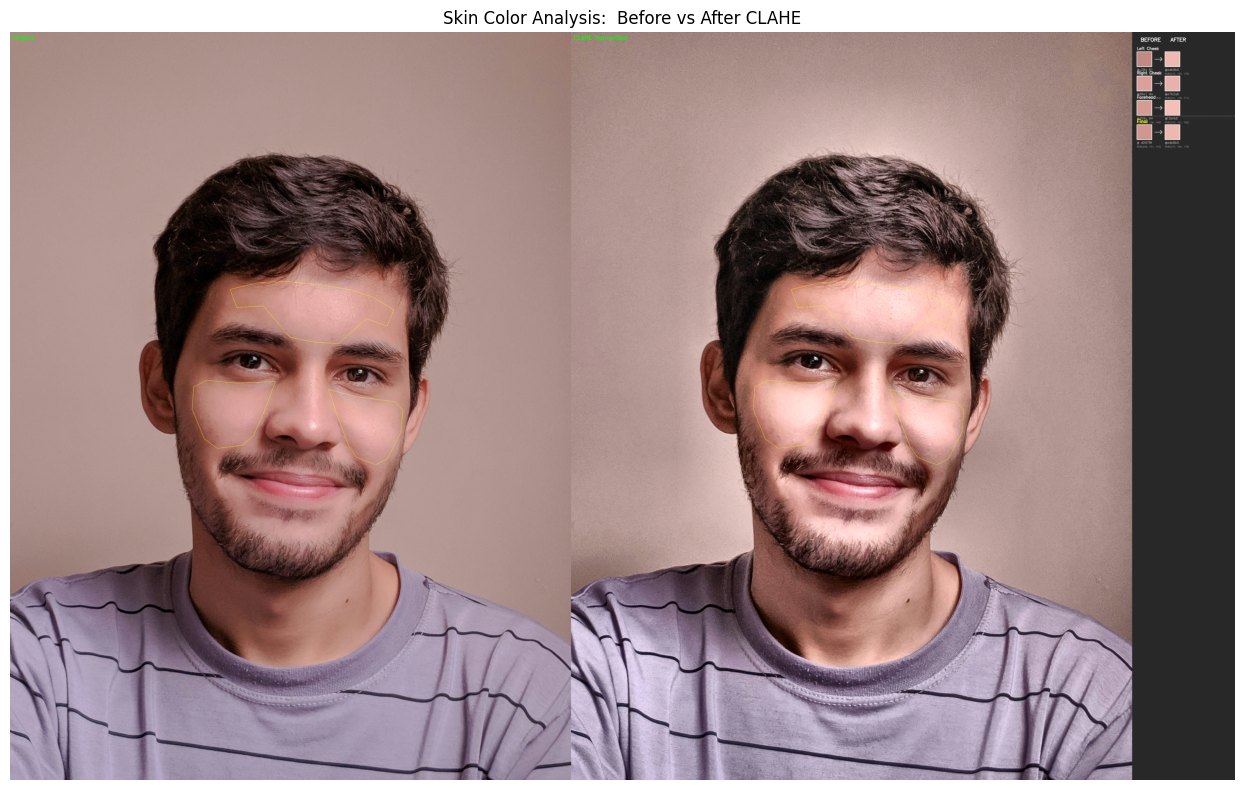


=== Skin Color Analysis ===

LEFT CHEEK:
  Before: #c28a 81  RGB(194, 138, 129)
  After:  #edb9b0  RGB(237, 185, 176)

RIGHT CHEEK:
  Before: #d9a1 9a  RGB(217, 161, 154)
  After:  #e7b2ab  RGB(231, 178, 171)

FOREHEAD:
  Before: #d59c 94  RGB(213, 156, 148)
  After:  #f3bfb6  RGB(243, 191, 182)

FINAL:
  Before: # d0978f  RGB(208, 151, 143)
  After:  #edb8b0  RGB(237, 184, 176)



In [334]:

image_path = "/home/freekitkallos/Downloads/man_test.jpg"
image = cv2.imread(image_path)
if image is None: 
    raise FileNotFoundError(image_path)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mp_image = mp.Image(image_format=mp. ImageFormat. SRGB, data=image_rgb)
result = face_landmarker. detect(mp_image)

if not result.face_landmarks:
    print("No face detected")
else:
    landmarks = result.face_landmarks[0]
    
    # Visualize with before/after comparison
    viz, results = visualize_skin_analysis_before_after(image, landmarks)
    
    plt.figure(figsize=(16, 8))
    plt.imshow(cv2.cvtColor(viz, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Skin Color Analysis:  Before vs After CLAHE")
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\n=== Skin Color Analysis ===\n")
    for region, data in results.items():
        print(f"{region.replace('_', ' ').upper()}:")
        print(f"  Before: {data['before']['hex']}  RGB{data['before']['RGB']}")
        print(f"  After:  {data['after']['hex']}  RGB{data['after']['RGB']}")
        print()

### Debug Cell - saving labelled landmark indices 